# Workflow

In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [7]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [8]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.


t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, integrated_beam_rising = stacked_beam_map(theta_c_rising, 
                                                            phi_c_rising, 
                                                            FWHM=1.1, 
                                                            NSIDE=nside, 
                                                            threshold = 0.0111)

In [9]:
full_bool_map, pixel_indices = reduce_bool_maps_LOR([bool_map_setting, bool_map_rising])
integrated_beam = integrated_beam_setting + integrated_beam_rising

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)
Tsky_operator_rising = generate_Tsky_proj(full_bool_map, theta_c_rising, phi_c_rising, FWHM=1.1)

In [10]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

Number of pixels:  473


### 2. Define Tdiode and Trec

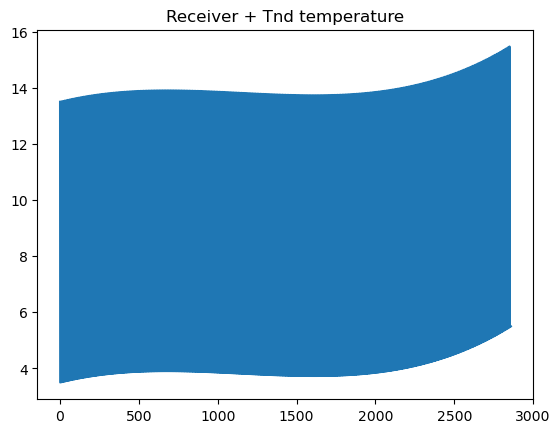

In [11]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

T_ndiode = 10.0
rec_params=np.array([4, 0.5, 0.5, 0.5]) # The receiver temperature and all
nd_rec_params = np.zeros(5)
nd_rec_params[0] = T_ndiode
nd_rec_params[1:] = rec_params

plt.title("Receiver + Tnd temperature")
plt.plot(nd_rec_operator @ nd_rec_params)

### 3. Define Gain and Noise

In [12]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])
gains_setting = gain_proj @ gain_params_setting


#gain_params_rising = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_rising = np.array([6.84507868, 0.14156859, 0.7441104, 0.77863955])
gains_rising  = gain_proj @ gain_params_rising 

# save the gain parameters
np.savez('outputs/GS5_db/gain_params.npz', gain_params_setting=gain_params_setting, gain_params_rising=gain_params_rising)

In [13]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)
noise_rising = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [14]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

Tsys_rising = Tsky_operator_rising @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_rising = Tsys_rising * (1+noise_rising) * gains_rising

## B. Sampling

In [15]:
def reduce_bool_maps_LAND(bool_maps):
    """
    Reduce a list of boolean maps using the "logical and" operation.
    """
    reduced_map = np.logical_and.reduce(bool_maps)
    # Get the pixel indices of the "1" pixels:
    pixel_indices = np.where(reduced_map)[0]
    return reduced_map, pixel_indices

In [16]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

# Convert theta/phi coordinates to HEALPix pixels
# pixels_c_rising = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
#           for theta, phi in zip(theta_c_rising, phi_c_rising)]
# bool_map_c_rising = np.zeros(hp.nside2npix(nside))
# bool_map_c_rising[pixels_c_rising] = 1

# LAND_bool_map, shared_pixel_indices = reduce_bool_maps_LAND([bool_map_c_setting, bool_map_c_rising])
# shared_indices = [list(pixel_indices).index(item) for item in shared_pixel_indices]

# # For a 1D array 'integrated_beam_setting'
# n_cal_pixs=1
# top_20_beam_indices = np.argpartition(integrated_beam[pixel_indices], -20)[-20:]
# top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
# calibration_indices = top_20_beam_indices[top_n_sky_indices]

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam[pixel_indices], -200)[-200:]
calibration_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]

In [17]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.ones(4)*0.
gain_prior_cov_inv[0] = 2.
gain_prior_mean = gain_params_setting

Tsky_prior_cov_inv = np.ones_like(sky_params)*0.2
Tsky_prior_cov_inv[calibration_indices] = 1e20

# Trec_prior_cov = np.ones_like(nd_rec_params)
# Trec_prior_cov[0] = 10.
Trec_prior_cov = np.zeros_like(nd_rec_params)
Trec_prior_cov_inv_list = [Trec_prior_cov, Trec_prior_cov]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [13]:
# class TOD_sim:
#     def __init__(self, t_list, theta_c, phi_c, 
#                  TOD, gain_proj, Tsky_proj, nd_rec_proj,
#                  ):
#         self.t_list = None
#         self.theta_c = None
#         self.phi_c = None

In [14]:
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting, TOD_rising],
                                    [t_list, t_list],
                                    [gain_proj, gain_proj],
                                    [Tsky_operator_setting, Tsky_operator_rising],
                                    [nd_rec_operator, nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc, logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv_list,
                                    local_Trec_prior_mean_list=[nd_rec_params, nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv,gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_params_setting,gain_params_rising],
                                    # local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=300,
                                    tol=1e-12)

Rank: 0, local id: 0, gain_sample 0: [6.3119599  0.42012908 0.26368879 0.05483653]
Rank: 0, local id: 0, noise_sample 0: [-4.7964758   2.12867586]
Rank: 0, local id: 1, gain_sample 0: [6.84530658 0.14260885 0.74661427 0.77734593]
Rank: 0, local id: 1, noise_sample 0: [-3.92275278  3.25773739]
Reached max iterations with fractional norm error 0.00030236525382434703.
Rank: 0, local id: 0, gain_sample 1: [6.31179526 0.41961417 0.26311366 0.05164815]
Rank: 0, local id: 0, noise_sample 1: [-4.68654219  1.98311777]
Rank: 0, local id: 1, gain_sample 1: [6.84474112 0.14270702 0.74219271 0.77697211]
Rank: 0, local id: 1, noise_sample 1: [-4.47922678  2.61279684]
Reached max iterations with fractional norm error 0.0003469629414808253.
Rank: 0, local id: 0, gain_sample 2: [6.31225784 0.41875303 0.2647327  0.05439363]
Rank: 0, local id: 0, noise_sample 2: [-5.48831452  1.4282509 ]
Rank: 0, local id: 1, gain_sample 2: [6.84481919 0.14286114 0.74176199 0.77863561]
Rank: 0, local id: 1, noise_sample 

#### Visualize the Tsky samples

In [15]:
# First, save the samples as npy files..

np.save("outputs/GS5_db/Tsys_samples.npy", Tsys_samples)
np.save("outputs/GS5_db/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS5_db/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [18]:

Tsys_samples = np.load('outputs/GS5_db/Tsys_samples.npy')
gain_samples = np.load('outputs/GS5_db/gain_samples.npy')
noise_samples = np.load('outputs/GS5_db/noise_samples.npy')


In [19]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
other_samples = np.hstack((gain_samples[0], Tsys_samples[:, num_pixels:], noise_samples[0]))
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)
Tresidual = Tmean - sky_params


NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

The mean residual is:  -0.06676075902027166
16th percentile:  -0.31329807405958693
84th percentile:  0.14248877105554894


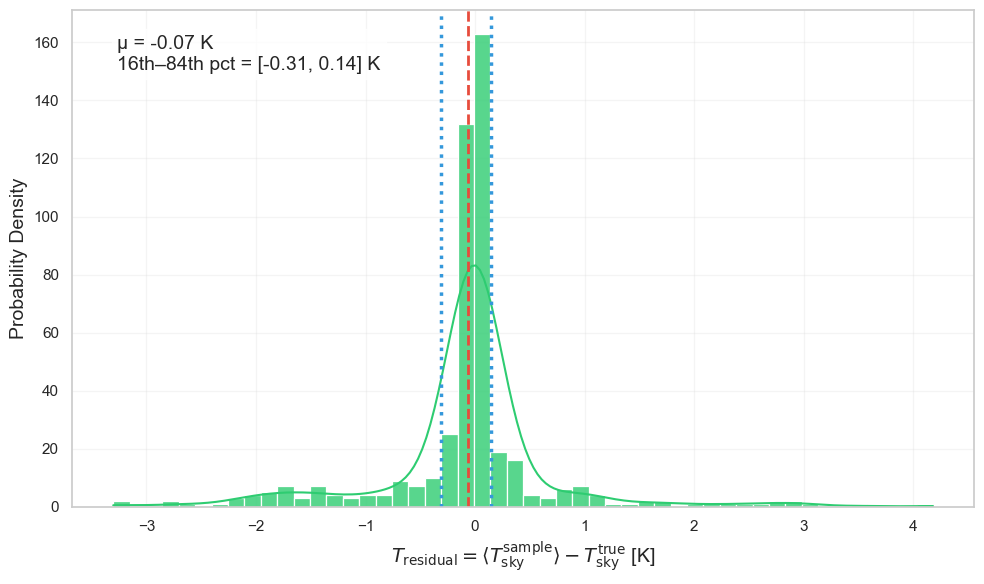

In [20]:
import seaborn as sns
import numpy as np
# Calculate residuals
residuals = Tmean - sky_params
from visualisation import plot_residual_histogram
plot_residual_histogram(residuals, save_path="./GS5_db_residuals_histogram.pdf")

In [18]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map


In [19]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

In [20]:
sky_min = np.min(sky_params)
sky_max = np.max(sky_params)

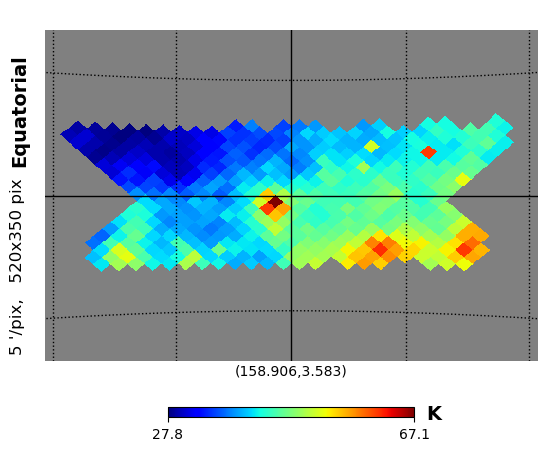

In [50]:
patch_true_map = view_patch_map(true_map, pixel_indices)

hp.gnomview(patch_true_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('outputs/GS5_db/true_map.pdf', bbox_inches='tight', 
            pad_inches=0.1)

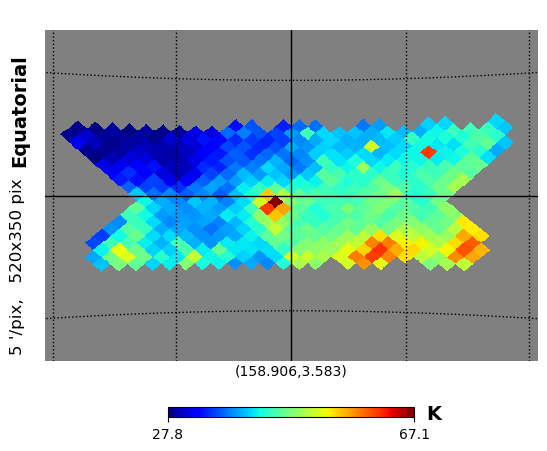

In [51]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS5_db/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

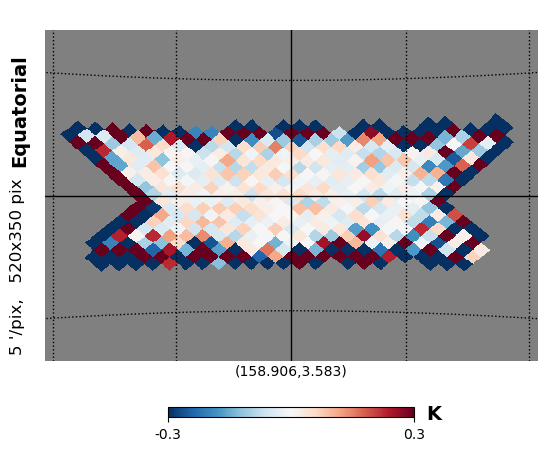

In [52]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-0.3, max=0.3,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS5_db/error_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

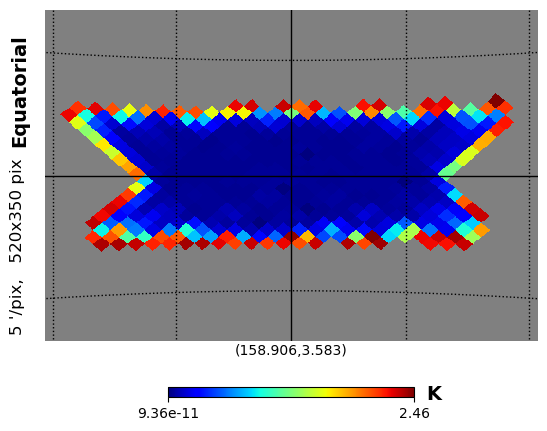

In [53]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)



hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS5_db/std_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

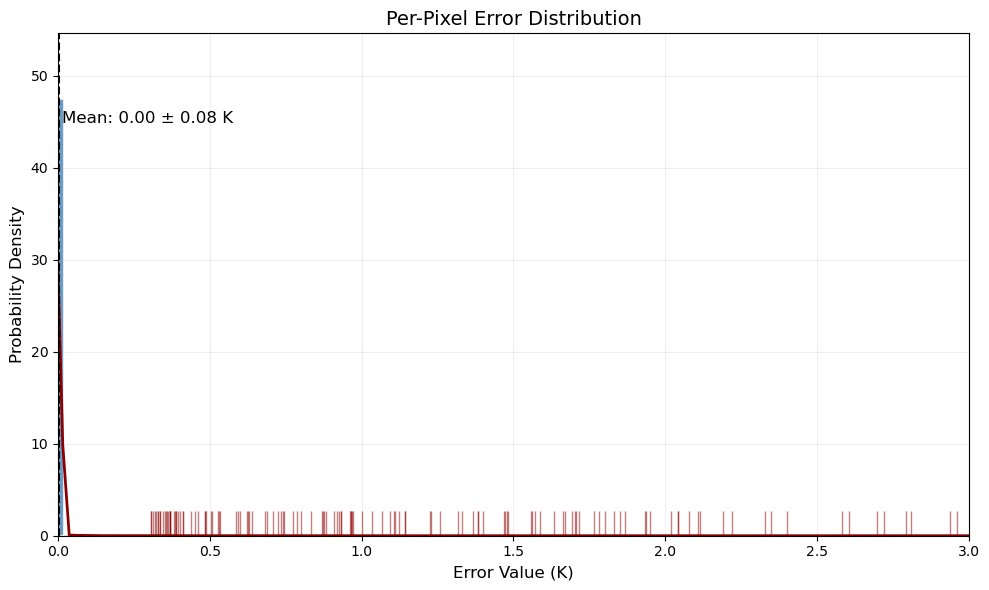

In [45]:
# Calculate errors
errors = (np.absolute(sample_mean_map - true_map)).flatten()

# Create styled histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, 
         bins=200, 
         color='steelblue', 
         edgecolor='white', 
         linewidth=1.5,
         density=True,
         alpha=0.8)

# Add KDE plot
import seaborn as sns
sns.kdeplot(errors, color='darkred', linewidth=2)

# Styling
plt.grid(alpha=0.2)
plt.title('Per-Pixel Error Distribution', fontsize=14)
plt.xlabel('Error Value (K)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add statistical annotations
mean_err = np.mean(errors)
std_err = np.std(errors)
plt.axvline(mean_err, color='black', linestyle='--', linewidth=1.5)
plt.text(mean_err+0.1*std_err, plt.ylim()[1]*0.9, 
         f'Mean: {mean_err:.2f} ± {std_err:.2f} K',
         fontsize=12)

plt.xlim(0, 3)  # Force x-axis range

# Optional: Add rug plot for outliers
sns.rugplot(errors[(errors < -0.3) | (errors > 0.3)], 
            height=0.05, 
            color='darkred',
            alpha=0.5)

plt.tight_layout()